In [2]:
!pip install requests


In [3]:
!pip install folium

In [4]:
!pip install pystac_client

In [5]:
!pip install branca

In [6]:
import requests
import folium
import folium.plugins
from folium import Map, TileLayer 
from pystac_client import Client 
import branca 
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# Please use the collection name similar to the one used in the STAC collection.
# Name of the collection for Vulcan Fossil Fuel CO₂ Emissions, Version 4. 
collection_name = "vulcan-ffco2-yeargrid-v4"

In [8]:
# Fetch the collection from STAC collections using the appropriate endpoint
# the 'requests' library allows a HTTP request possible
collection_vulcan = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()

In [9]:
collection_vulcan


{'id': 'vulcan-ffco2-yeargrid-v4',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/vulcan-ffco2-yeargrid-v4/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/vulcan-ffco2-yeargrid-v4'}],
 'title': 'Vulcan Fossil Fuel CO₂ Emissions v4.0',
 'extent': {'spatial': {'bbox': [[-128.22654896758996,
     22.857766529124284,
     -65.30917199495289,
     51.44087947724907]]},
  'temporal': {'interval': [['2010-01-01 00:00:00+00',
     '2021-12-31 00:00:00+00']]}},
 'license': 'CC-BY-NC-4.0',
 'renders': {'air-co2': {'assets': ['air-co2'],
   'rescale': [[0, 500]],
   'colormap_name': 'spectral_r'},
  'cmt-co2': {'assets': ['cmt

In [10]:
def get_item_count(collection_id):
    count = 0
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"

    while True:
        response = requests.get(items_url)

        if not response.ok:
            print("error getting items")
            exit()

        stac = response.json()
        count += int(stac["context"].get("returned", 0))
        next = [link for link in stac["links"] if link["rel"] == "next"]

        if not next:
            break
        items_url = next[0]["href"]

    return count

In [11]:
number_of_items = get_item_count(collection_name)
items_vulcan = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit={number_of_items}").json()["features"]
print(f"Found {len(items_vulcan)} items")


Found 12 items


In [12]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items_vulcan[0]

{'id': 'vulcan-ffco2-yeargrid-v4-2021',
 'bbox': [-128.22654896758996,
  22.857766529124284,
  -65.30917199495289,
  51.44087947724907],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/vulcan-ffco2-yeargrid-v4'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/vulcan-ffco2-yeargrid-v4'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/vulcan-ffco2-yeargrid-v4/items/vulcan-ffco2-yeargrid-v4-2021'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/collections/vulcan-ffco2-yeargrid-v4/items/vulcan-ffco2-yeargrid-v4-2021/map?assets=total-co2&rescale=0%2C500&colormap_name=spectral_r',
   'rel': 'preview',
   'type': 'text/html'}],
 'assets

In [13]:
# To access the year value from each item more easily, this will let us query more explicitly by year and month (e.g., 2020-02)
items = {item["properties"]["start_datetime"][:4]: item for item in items_vulcan} 
# rh = Heterotrophic Respiration
asset_name = "total-co2"

In [14]:
rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}

In [16]:
color_map = "spectral_r" # please refer to matplotlib library if you'd prefer choosing a different color ramp.
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html

# To change the year and month of the observed parameter, you can modify the "items['YYYY-MM']" statement
# For example, you can change the current statement "items['2003-12']" to "items['2016-10']" 
_2021_tile = requests.get(
    f"{RASTER_API_URL}/collections/{items['2021']['collection']}/items/{items['2021']['id']}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale=0,150", 
).json()
_2021_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/vulcan-ffco2-yeargrid-v4/items/vulcan-ffco2-yeargrid-v4-2021/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=total-co2&color_formula=gamma+r+1.05&colormap_name=spectral_r&rescale=0%2C150'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-128.22654896758996,
  22.857766529124284,
  -65.30917199495289,
  51.44087947724907],
 'center': [-96.76786048127143, 37.14932300318668, 0]}

In [17]:
_2010_tile = requests.get(
    f"{RASTER_API_URL}/collections/{items['2010']['collection']}/items/{items['2010']['id']}/tilejson.json?"

    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale=0,150", 
).json()
_2010_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/vulcan-ffco2-yeargrid-v4/items/vulcan-ffco2-yeargrid-v4-2010/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=total-co2&color_formula=gamma+r+1.05&colormap_name=spectral_r&rescale=0%2C150'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-128.22654896758996,
  22.857766529124284,
  -65.30917199495289,
  51.44087947724907],
 'center': [-96.76786048127143, 37.14932300318668, 0]}

In [18]:
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=6)


# Define the first map layer with the CO2 Flux data for December 2022
map_layer_2021 = TileLayer(
    tiles=_2021_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution 
    name='2021 Total CO2 Fossil Fuel Emissions', # Title for the layer
    overlay=True, # The layer can be overlaid on the map
    opacity=0.8, # Adjust the transparency of the layer
)
# Add the first layer to the Dual Map 
map_layer_2021.add_to(map_.m1)

map_layer_2010 = TileLayer(
    tiles=_2010_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution 
    name='2010 Total CO2 Fossil Fuel Emissions', # Title for the layer
    overlay=True, # The layer can be overlaid on the map
    opacity=0.8, # Adjust the transparency of the layer
)
# Add the first layer to the Dual Map 
map_layer_2010.add_to(map_.m2)

map_

In [19]:
texas_aoi = {
    "type": "Feature", # Create a feature object
    "properties": {},
    "geometry": { # Set the bounding coordinates for the polygon
        "coordinates": [
            [
                [-95, 29], # South-east bounding coordinate
                [-95, 33], # North-east bounding coordinate
                [-104,33], # North-west bounding coordinate
                [-104,29], # South-west bounding coordinate
                [-95, 29]  # South-east bounding coordinate (closing the polygon)
            ]
        ],
        "type": "Polygon",
    },
}

In [20]:
# Create a new map to display the generated polygon
# We'll plug in the coordinates for a location
# Central to the study area and a reasonable zoom level
aoi_map = Map(

    # Base map is set to OpenStreetMap
    tiles="OpenStreetMap",

    # Define the spatial properties for the map
    location=[
        30,-100
    ],

    # Set the zoom value
    zoom_start=6,
)

# Insert the polygon to the map
folium.GeoJson(texas_aoi, name="Texas, USA").add_to(aoi_map)

# Visualize the map
aoi_map

In [21]:
# Check total number of items available within the collection
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 12 items


In [22]:
items[0]

{'id': 'vulcan-ffco2-yeargrid-v4-2021',
 'bbox': [-128.22654896758996,
  22.857766529124284,
  -65.30917199495289,
  51.44087947724907],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/vulcan-ffco2-yeargrid-v4'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/vulcan-ffco2-yeargrid-v4'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/vulcan-ffco2-yeargrid-v4/items/vulcan-ffco2-yeargrid-v4-2021'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/collections/vulcan-ffco2-yeargrid-v4/items/vulcan-ffco2-yeargrid-v4-2021/map?assets=total-co2&rescale=0%2C500&colormap_name=spectral_r',
   'rel': 'preview',
   'type': 'text/html'}],
 'assets

In [23]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
# Create a function that retrieves information regarding a specific granule using its asset name and raster identifier and generates the statistics for it

# The function takes an item (granule) and a JSON (polygon) as input parameters
def generate_stats(item, geojson):

    # A POST request is made to submit the data associated with the item of interest (specific observation) within the boundaries of the polygon to compute its statistics
    result = requests.post(

        # Raster API Endpoint for computing statistics
        f"{RASTER_API_URL}/cog/statistics",

        # Pass the URL to the item, asset name, and raster identifier as parameters
        params={"url": item["assets"][asset_name]["href"]},

        # Send the GeoJSON object (polygon) along with the request
        json=geojson,

    # Return the response in JSON format
    ).json()

    # Print the result
    print(result)

    # Return a dictionary containing the computed statistics along with the item's datetime information.
    return {
        **result["properties"],
        "datetime": item["properties"]["start_datetime"][:10],
    }

# Generate a for loop that iterates over all the existing items in the collection
for item in items:

    # The loop will then retrieve the information for the start datetime of each item in the list
    print(item["properties"]["start_datetime"][:10])

    # Exit the loop after printing the start datetime for the first item in the collection
    break

2021-01-01


In [24]:
%%time
# %%time = Wall time (execution time) for running the code below

# Generate statistics using the created function "generate_stats" within the bounding box defined by the polygon
stats = [generate_stats(item, texas_aoi) for item in items]

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-95.0, 29.0], [-95.0, 33.0], [-104.0, 33.0], [-104.0, 29.0], [-95.0, 29.0]]]}, 'properties': {'statistics': {'b1': {'min': 1.7858106104995386e-07, 'max': 3768974.0, 'mean': 261.6907958984375, 'count': 296120.0625, 'sum': 77491896.0, 'std': 11522.940944047226, 'median': 7.39058256149292, 'majority': 0.19903208315372467, 'minority': 1.7858106104995386e-07, 'unique': 242084.0, 'histogram': [[296498.0, 13.0, 6.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0], [1.7858106104995386e-07, 376897.40625, 753794.8125, 1130692.25, 1507589.625, 1884487.0, 2261384.5, 2638281.75, 3015179.25, 3392076.75, 3768974.0]], 'valid_percent': 95.72, 'masked_pixels': 13265.0, 'valid_pixels': 296520.0, 'percentile_2': 0.20036202669143677, 'percentile_98': 1811.0848388671875}}}}
{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-95.0, 29.0], [-95.0, 33.0], [-104.0, 33.0], [-104.0, 29.0], [-95.0, 29.0]]]}, 'properties': {'statistics': {'

In [25]:
# Print the stats for the first item in the collection
stats[0]

{'statistics': {'b1': {'min': 1.7858106104995386e-07,
   'max': 3768974.0,
   'mean': 261.6907958984375,
   'count': 296120.0625,
   'sum': 77491896.0,
   'std': 11522.940944047226,
   'median': 7.39058256149292,
   'majority': 0.19903208315372467,
   'minority': 1.7858106104995386e-07,
   'unique': 242084.0,
   'histogram': [[296498.0, 13.0, 6.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0],
    [1.7858106104995386e-07,
     376897.40625,
     753794.8125,
     1130692.25,
     1507589.625,
     1884487.0,
     2261384.5,
     2638281.75,
     3015179.25,
     3392076.75,
     3768974.0]],
   'valid_percent': 95.72,
   'masked_pixels': 13265.0,
   'valid_pixels': 296520.0,
   'percentile_2': 0.20036202669143677,
   'percentile_98': 1811.0848388671875}},
 'datetime': '2021-01-01'}

In [26]:
def clean_stats(stats_json) -> pd.DataFrame:

    # Normalize the JSON data
    df = pd.json_normalize(stats_json)

    # Replace the naming "statistics.b1" in the columns
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]

    # Set the datetime format
    df["date"] = pd.to_datetime(df["datetime"])

    # Return the cleaned format
    return df

# Apply the generated function on the stats data
df = clean_stats(stats)

# Display the stats for the first 5 granules in the collection in the table
# Change the value in the parenthesis to show more or a smaller number of rows in the table
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2021-01-01,1.785811e-07,3768974.0,261.690796,296120.0625,77491896.0,11522.940944,7.390583,0.199032,1.785811e-07,242084.0,"[[296498.0, 13.0, 6.0, 0.0, 1.0, 0.0, 0.0, 0.0...",95.72,13265.0,296520.0,0.200362,1811.084839,2021-01-01
1,2020-01-01,1.622880e-07,3548930.5,254.962936,296120.0625,75499640.0,10912.768301,6.836727,0.180845,1.622880e-07,242118.0,"[[296495.0, 14.0, 6.0, 2.0, 1.0, 0.0, 0.0, 1.0...",95.72,13265.0,296520.0,0.182224,1713.106445,2020-01-01
2,2019-01-01,1.877873e-07,3369803.0,276.884796,296120.0625,81991144.0,11799.911186,7.814598,0.527155,1.877873e-07,242967.0,"[[296495.0, 13.0, 6.0, 3.0, 0.0, 0.0, 0.0, 1.0...",95.72,13265.0,296520.0,0.212244,1882.463623,2019-01-01
3,2018-01-01,1.853067e-07,3868559.5,278.522980,296120.0625,82476240.0,12222.416782,7.711860,0.519930,1.853067e-07,242928.0,"[[296497.0, 14.0, 6.0, 0.0, 0.0, 0.0, 1.0, 0.0...",95.72,13265.0,296520.0,0.208977,1912.632568,2018-01-01
4,2017-01-01,1.802980e-07,4050962.5,271.169403,296120.0625,80298704.0,13290.472377,7.446557,0.505795,1.802980e-07,242922.0,"[[296499.0, 14.0, 3.0, 0.0, 0.0, 1.0, 1.0, 0.0...",95.72,13265.0,296520.0,0.203270,1775.784790,2017-01-01


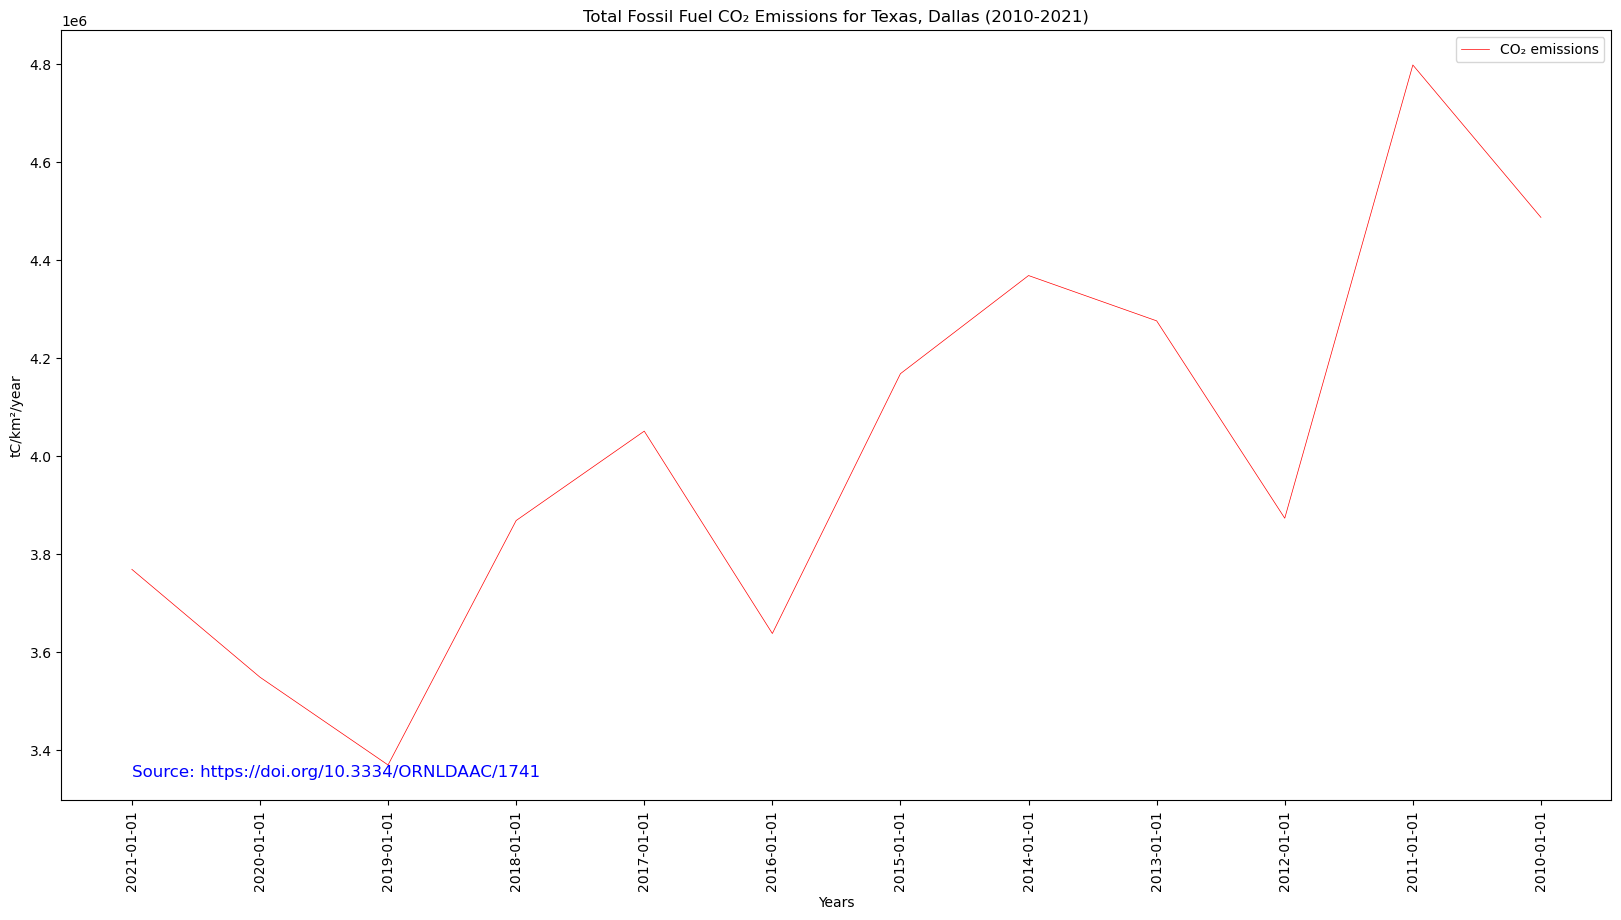

In [28]:
# Figure size: 20 representing the width, 10 representing the height
fig = plt.figure(figsize=(20, 10))

plt.plot(
    df["datetime"], # X-axis: sorted datetime
    df["max"], # Y-axis: maximum CO₂
    color="red", # Line color
    linestyle="-", # Line style
    linewidth=0.5, # Line width
    label="CO₂ emissions", # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Years")

# Insert label for the Y-axis
plt.ylabel("tC/km²/year")
plt.xticks(rotation = 90)

# Insert title for the plot
plt.title("Total Fossil Fuel CO₂ Emissions for Texas, Dallas (2010-2021)")

# Add data citation
plt.text(
    df["datetime"].iloc[0],           # X-coordinate of the text
    df["max"].min(),                  # Y-coordinate of the text




    # Text to be displayed
    "Source: https://doi.org/10.3334/ORNLDAAC/1741",                  
    fontsize=12,                             # Font size
    horizontalalignment="left",              # Horizontal alignment
    verticalalignment="top",                 # Vertical alignment
    color="blue",                            # Text color
)


# Plot the time series
plt.show()

